In [28]:
n_try = 1

In [23]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
from os.path import isdir
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import MaxPooling2D

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import L1L2

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPool2D

from tensorflow.keras.optimizers import Adam

import pandas as pd

# Data preparation

In [31]:

class DataProperties:
    main_dir = '/content/drive/MyDrive/ML/Datasets/4.Food5k/'
    validation_dir = main_dir + 'validation/'
    train_dir = main_dir + 'train/'
    test_dir = main_dir + 'test/'

    hackathon_dir = f'/content/drive/MyDrive/ML/Unox/{n_try}/'
    model_save_dir = hackathon_dir + 'Models/'
    histories_dir = hackathon_dir + 'Histories/'


def make_dirs(dirs):
    for dir in dirs:
        if not isdir(dir):
            os.mkdir(dir)


make_dirs(
    [
     DataProperties.hackathon_dir,
     DataProperties.train_dir,
     DataProperties.validation_dir,
     DataProperties.model_save_dir,
     DataProperties.histories_dir,
    ]
)

assert(isdir(DataProperties.main_dir))
assert(isdir(DataProperties.model_save_dir))

assert(isdir(DataProperties.train_dir))
assert(isdir(DataProperties.validation_dir))
assert(isdir(DataProperties.histories_dir))

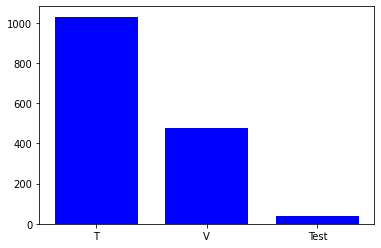

In [5]:
def calc_files(directory):
    total_files = 0

    for base, _, files in os.walk(directory):
        # print('Searching in : ',base)
        for _ in files:
            total_files += 1
    return total_files

x = ['T', 'V', 'Test']
y = [
     calc_files(dir) for dir in [
                                 DataProperties.train_dir, DataProperties.validation_dir,
                                 DataProperties.test_dir]
]

fig, ax = plt.subplots()
ax.bar(x, y, width = 0.75, color = 'blue')
plt.show()

In [6]:
target_shape = (256, 256)

train_batch_size = 8

width_shift_range = 0.09
height_shift_range = 0.09
rotation_range = 0.2
zoom_range = [0.9, 1.1]

In [7]:
train_use = 1

def preprocess(image):
    image = image / 255.
    return image

train_generator = ImageDataGenerator(
    validation_split = 1 - train_use,

    preprocessing_function = preprocess,
    # samplewise_center = 
    # featurewise_center = 

    width_shift_range = width_shift_range,
    height_shift_range = height_shift_range,
    rotation_range = rotation_range,
    horizontal_flip = True,
    vertical_flip = True,

    # brightness_range = 
    zoom_range = zoom_range
)

train_flow = train_generator.flow_from_directory(
    directory = DataProperties.train_dir,

    target_size = target_shape,
    color_mode = 'rgb',
    # classes = 
    class_mode = 'sparse',
    batch_size = train_batch_size,
    subset = 'training',
    shuffle = True,
    seed = 123
)

print(f'Use {train_flow.n} images for train flow')

Found 1031 images belonging to 2 classes.
Use 1031 images for train flow


In [8]:
val_use = 1  # 0.4

val_generator = ImageDataGenerator(
    validation_split = 1 - val_use,

    preprocessing_function = preprocess,
    # samplewise_center = 
    # featurewise_center = 

    width_shift_range = width_shift_range,
    height_shift_range = height_shift_range,
    rotation_range = rotation_range,
    horizontal_flip = True,
    vertical_flip = True,

    # brightness_range = 
    zoom_range = zoom_range
)

val_flow = val_generator.flow_from_directory(
    directory = DataProperties.validation_dir,

    target_size = target_shape,
    color_mode = 'rgb',
    # classes = 
    class_mode = 'sparse',
    # batch_size = None,
    subset = 'training',
    shuffle = False,
    seed = 123
)

print(f'Use {val_flow.n} images for validation flow')

Found 475 images belonging to 2 classes.
Use 475 images for validation flow


In [9]:
test_use = 1

test_generator = ImageDataGenerator(
    validation_split = 1 - test_use,

    preprocessing_function = preprocess,
    # samplewise_center = 
    # featurewise_center = 

    # width_shift_range = 2,
    # height_shift_range = 2,
    # rotation_range = 0.5,
    # horizontal_flip = True,
    # vertical_flip = True,

    # brightness_range = 
    # zoom_range = [-0.2, 0.2]
)

test_flow = test_generator.flow_from_directory(
    directory = DataProperties.test_dir,

    target_size = target_shape,
    color_mode = 'rgb',
    # classes = 
    class_mode = 'sparse',
    # batch_size = None,
    subset = 'training',
    shuffle = False,
    seed = 123
)

print(f'Use {test_flow.n} images for test flow')

Found 40 images belonging to 2 classes.
Use 40 images for test flow


In [10]:
def visualize(batch, labels, n_subplots, class_indices, figsize = (15, 15)):
    plt.figure(figsize = figsize)
    for i in range(n_subplots): #(batch_size):
        ax = plt.subplot(
            int(np.sqrt(n_subplots)), 
            int(np.sqrt(n_subplots)), 
            i + 1
        )
        plt.imshow(batch[i])
        plt.title(labels[i])
        # plt.title(get_class_name(class_indices, labels[i]))
        plt.axis("off")


def visualize_flow(n, flow):

    how_many_to_show = n
    # flow = train_flow
    for _ in range(1):
        batch, labels = flow.next()
        print(batch.shape, np.max(batch))
        assert np.max(batch) <= 1.01
        assert np.min(batch) >= 0.0
        
        visualize(
            batch,
            labels,
            how_many_to_show,
            class_indices = flow.class_indices,
            figsize=(10, 10)
        )

In [11]:
# visualize_flow(
#     4,
#     train_flow
# )

# visualize_flow(
#     4, 
#     val_flow
# )

# Model preparation

In [12]:
def construct_cnn(input_shape):
    model = tf.keras.models.Sequential()

    model.add(Conv2D(filters = 96, kernel_size = (11, 11), strides = 4, padding = 'valid', activation = 'relu', input_shape = (256, 256, 3)))
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'valid', data_format = None))

    model.add(Conv2D(filters = 96, kernel_size = (6, 6), strides = 4, padding = 'valid', activation = 'relu', input_shape = (256, 256, 3)))
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'valid', data_format = None))

    model.add(Flatten())
    model.add(Dense(10, activation = 'relu'))
    model.add(Dense(1, activation= 'sigmoid'))

    model.compile(
        optimizer = 'sgd',
        # optimizer = Adam(learning_rate = 0.001),
        metrics = ['accuracy'],
        loss = 'binary_crossentropy'
    )

    return model

In [13]:
def construct_vgg16(input_shape):
    model = tf.keras.models.Sequential()
    model.add(Conv2D(input_shape=(input_shape),filters=64,kernel_size=(3,3),padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=1, activation="sigmoid"))

    model.compile(
        metrics = 'accuracy',
        loss = 'binary_crossentropy',
        optimizer = 'sgd'
    )

    return model

In [14]:
def construct_model(name, input_shape):
    if name == 'CNN':
        return construct_cnn(input_shape)

    if name == 'VGG16':
        return construct_vgg16(input_shape)

In [15]:
def calc_steps(flow):
    return flow.n // flow.batch_size

train_steps = calc_steps(train_flow)
val_steps = calc_steps(val_flow)
test_steps = calc_steps(test_flow)


def fit_models(models_dict, stopper, epochs = 50):
    histories = {}
    for model_name, model in models_dict.items():
        print(f'fitting {model_name}')

        histories[model_name] = model.fit(
            train_flow,
            steps_per_epoch = train_steps,

            validation_data = val_flow,
            validation_steps = val_steps,

            epochs = epochs,
            callbacks = [stopper]
        )
    return histories

In [16]:
models = {
    'CNN': construct_model('CNN', input_shape = (target_shape[0], target_shape[1], 3)),
    'VGG16': construct_model('VGG16', input_shape = (target_shape[0], target_shape[1], 3))
}

In [17]:
early_stopper = EarlyStopping(
    monitor = 'val_loss',
    mode = 'min',
    patience = 3
)

histories = fit_models(
    {'CNN': models['CNN']},
    stopper = early_stopper,
    epochs = 3
)

fitting CNN
Epoch 1/3
128/128 [==============================] - 753s 6s/step - loss: 0.6408 - accuracy: 0.6315 - val_loss: 0.5552 - val_accuracy: 0.7612
Epoch 2/3
128/128 [==============================] - 36s 279ms/step - loss: 0.5631 - accuracy: 0.7263 - val_loss: 0.5258 - val_accuracy: 0.7522
Epoch 3/3
128/128 [==============================] - 36s 280ms/step - loss: 0.5136 - accuracy: 0.7713 - val_loss: 0.4919 - val_accuracy: 0.7768


# Another model

In [ ]:
histories_vgg16 = fit_models(
    {'VGG16': models['VGG16']},
    stopper = early_stopper,
    epochs = 2
)

fitting VGG16
Epoch 1/5
  9/128 [=>............................] - ETA: 36:36 - loss: 0.9175 - accuracy: 0.5556

KeyboardInterrupt: ignored

# Saving models

In [32]:
def save_models(models_dict):

    for model_name, model in models_dict.items():
        model.save(
            f'{DataProperties.model_save_dir}{model_name}'
        )

save_models(
    {
        'CNN': models['CNN']
    }
)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/Unox/1/Models//CNN/assets


# Save histories

In [33]:
def save_histories(hist_dict, save_dir):
    for model_name, hist in hist_dict.items():
        df = pd.DataFrame(hist.history)
        df.to_csv(f'{save_dir}{model_name}_history.csv')

save_histories(
    histories,
    save_dir = DataProperties.histories_dir
)